**Import libs**

In [21]:
from typing import List, Dict, Set, Tuple, Callable
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange
import pickle

**Import torch related libs**

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import SubsetRandomSampler

**Get Device**

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("GPU available")
else:
    DEVICE = torch.device("cpu")
    print("GPU not available")

GPU available


**Make a data directory**

In [4]:
!mkdir -p dataset/CIFAR10/{training,testing}
!mkdir -p model

**Global variables (If Any)**

In [5]:
paths = defaultdict(lambda: "")
paths["training_data"] = "/content/dataset/CIFAR10/training/"
paths["testing_data"] = "/content/dataset/CIFAR10/testing/"
paths["model_dir"] = "/content/model/"

In [6]:
lables = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**Download Training and Testing Data**

In [7]:
training_transforms = transforms.Compose([transforms.ToTensor()])
training_data = datasets.CIFAR10(root=paths["training_data"], train=True, download=True, transform=training_transforms)
testing_transforms = transforms.Compose([transforms.ToTensor()])
testing_data = datasets.CIFAR10(root=paths["testing_data"], train=False, download=True, transform=testing_transforms)

Extracting /content/dataset/CIFAR10/training/cifar-10-python.tar.gz to /content/dataset/CIFAR10/training/


Extracting /content/dataset/CIFAR10/testing/cifar-10-python.tar.gz to /content/dataset/CIFAR10/testing/


**Load data to iterators**

In [8]:
indices = np.arange(0,len(training_data))
np.random.shuffle(indices)

In [9]:
train_len = int(0.9 * len(training_data))
val_len = int(0.1 * len(training_data))

In [10]:
train_set = DataLoader(training_data, batch_size=32, sampler=SubsetRandomSampler(indices[:train_len]))
val_set = DataLoader(training_data, batch_size=32, sampler=SubsetRandomSampler(indices[-val_len:]))
test_set = DataLoader(testing_data, batch_size=32, shuffle=True)

**Show random four images in the training set**

In [11]:
def show_images(dataiter: iter, n: int = 4):
    
    x, y = dataiter.next()

    fig, ax = plt.subplots(1, n, facecolor="white")

    for i, img in enumerate(x):
        if i >= n:
            break
        else:
            # convert from CHW to HWC from 3x32x32 to 32x32x3
            img = img.numpy()
            ax[i].imshow(img.transpose(1,2,0))
            ax[i].set_title(lables[y[i]])
            ax[i].set_xticks([])
            ax[i].set_yticks([])

    return

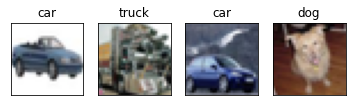

In [12]:
show_images(iter(train_set))

**Plot Training and Validation Metric**

In [13]:
def plot(metric, title):

    def separate_data(arr):
        # Lists
        t_data = []
        v_data = []
        
        # Separate training and validation data
        for t,v in arr:
            t_data.append(t)
            v_data.append(v)

        return t_data, v_data


    # Init
    plt.figure(facecolor='white', figsize=(20,5))

    # Plot loss
    t_loss, v_loss = separate_data(metric["loss"])
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(t_loss, color='teal', label='Training')
    plt.plot(v_loss, color='blue', label='Validation')
    plt.legend()
    
    # Plot accuracy
    t_acc, v_acc = separate_data(metric["acc"])
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(t_acc, color='teal', label='Training')
    plt.plot(v_acc, color='blue', label='Validation')
    plt.legend()

    # Show plot
    plt.suptitle(title)
    plt.subplots_adjust(wspace=0.5)
    plt.show()

    return

**Build Model**

In [30]:
class CNN(nn.Module):
    def __init__(self, 
                 training_dataset: DataLoader, 
                 validation_dataset: DataLoader, 
                 testing_dataset: DataLoader,
                 desc: str, 
                 is_batchnorm: bool = False,
                 is_dropout: bool = False,
                 is_dropout_incremental: bool = False):

        # parent init
        super().__init__()

        # General variables
        self.desc = desc
        self.is_debug  = False # By default False
        self.is_batchnorm = is_batchnorm
        self.is_dropout = is_dropout
        self.is_dropout_incremental = is_dropout_incremental
        self.evaluation_metrics = {}

        # Data set
        self.training_dataset = training_dataset
        self.validation_dataset = validation_dataset
        self.testing_dataset = testing_dataset

        # Common layers
        self.pool = nn.MaxPool2d(2)
        self.dout = nn.Dropout2d(0.2)

        # Block 1
        self.conv11 = nn.Conv2d(3, 32, 3)
        self.conv12 = nn.Conv2d(32, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.dout1 = nn.Dropout2d(0.2)

        # Block 2
        self.conv21 = nn.Conv2d(32, 64, 3)
        self.conv22 = nn.Conv2d(64, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.dout2 = nn.Dropout2d(0.3)

        # Block 3
        self.conv31 = nn.Conv2d(64, 128, 3)
        self.conv32 = nn.Conv2d(128, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.dout3 = nn.Dropout2d(0.4)

        # Full connected Layer 1
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.doutfc1 = nn.Dropout2d(0.5)

        # Full connected Layer 2
        self.fc2 = nn.Linear(128, 10)

        # Get the network on GPU/CPU
        self.to(DEVICE)
        
        return

    def forward(self, x, is_debug: bool = False):
        # Block 1 Layer 1
        x = F.pad(x, (1, 1, 1, 1))
        x = F.relu(self.conv11(x))
        self.__debug_print(f"Conv2d: {str(x.size())}")

        # Block 1 Layer 1 Batch Norm
        if self.is_batchnorm:
            x = self.bn1(x)
            self.__debug_print(f"BN2d: {str(x.size())}")

        # Block 1 Layer 2
        x = F.pad(x, (1, 1, 1, 1))
        x = F.relu(self.conv12(x))
        self.__debug_print(f"Conv2d: {str(x.size())}")

        # Block 1 Layer 2 Batch Norm
        if self.is_batchnorm:
            x = self.bn1(x)
            self.__debug_print(f"BN2d: {str(x.size())}")

        # Block 1 Maxpool
        x = self.pool(x)
        self.__debug_print(f"MaxPool2d: {str(x.size())}")

        # Block 1 Dropout
        if self.is_dropout:
            if self.is_dropout_incremental:
                x = self.dout1(x)
                self.__debug_print(f"Dout2d_i: {str(x.size())}")
            else:
                x = self.dout(x)
                self.__debug_print(f"Dout2d: {str(x.size())}")

        # Block 2 Layer 1
        x = F.pad(x, (1, 1, 1, 1))
        x = F.relu(self.conv21(x))
        self.__debug_print(f"Conv2d: {str(x.size())}")

        # Block 2 Layer 1 Batch Norm
        if self.is_batchnorm:
            x = self.bn2(x)
            self.__debug_print(f"BN2d: {str(x.size())}")

        # Block 2 Layer 2
        x = F.pad(x, (1, 1, 1, 1))
        x = F.relu(self.conv22(x))
        self.__debug_print(f"Conv2d: {str(x.size())}")

        # Block 2 Layer 2 Batch Norm
        if self.is_batchnorm:
            x = self.bn2(x)
            self.__debug_print(f"BN2d: {str(x.size())}")

        # Block 2 Maxpool
        x = self.pool(x)
        self.__debug_print(f"MaxPool2d: {str(x.size())}")

        # Block 2 Dropout
        if self.is_dropout:
            if self.is_dropout_incremental:
                x = self.dout2(x)
                self.__debug_print(f"Dout2d_i: {str(x.size())}")
            else:
                x = self.dout(x)
                self.__debug_print(f"Dout2d: {str(x.size())}")

        # Block 3 Layer 1
        x = F.pad(x, (1, 1, 1, 1))
        x = F.relu(self.conv31(x))
        self.__debug_print(f"Conv2d: {str(x.size())}")

        # Block 3 Layer 1 Batch Norm
        if self.is_batchnorm:
            x = self.bn3(x)
            self.__debug_print(f"BN2d: {str(x.size())}")

        # Block 3 Layer 2
        x = F.pad(x, (1, 1, 1, 1))
        x = F.relu(self.conv32(x))
        self.__debug_print(f"Conv2d: {str(x.size())}")

        # Block 3 Layer 2 Batch Norm
        if self.is_batchnorm:
            x = self.bn3(x)
            self.__debug_print(f"BN2d: {str(x.size())}")

        # Block 3 Maxpool
        x = self.pool(x)
        self.__debug_print(f"MaxPool2d: {str(x.size())}")

        # Block 3 Dropout
        if self.is_dropout:
            if self.is_dropout_incremental:
                x = self.dout3(x)
                self.__debug_print(f"Dout2d_i: {str(x.size())}")
            else:
                x = self.dout(x)
                self.__debug_print(f"Dout2d: {str(x.size())}")

        # Re-Shaping
        x = x.view(x.shape[0], -1)
        self.__debug_print(f"Re-Shaping: {str(x.size())}")

        # Fully connected Layer 1
        x = F.relu(self.fc1(x))
        self.__debug_print(f"FC-1: {str(x.size())}")

        # Fully connected Layer 1 Dropout
        if self.is_dropout:
            if self.is_dropout_incremental:
                x = self.doutfc1(x)
                self.__debug_print(f"Dout2d_i: {str(x.size())}")
            else:
                x = self.dout(x)
                self.__debug_print(f"Dout2d: {str(x.size())}")

        # Fully connected layer 2
        x = F.softmax(self.fc2(x), dim=1)
        self.__debug_print(f"FC-2: {str(x.size())}")
        
        return x

    def __debug_print(self, x: str):
        if self.is_debug:
            print(x)
        return

    def debug(self, C: int, W: int, H: int):
        self.is_debug = True # Turn Debug Flag On

        # Generate a random data
        x = torch.randn(C,W,H).view(-1,C,W,H)
        x = x.to(DEVICE)

        # Feed Forward
        self.forward(x, True)

        self.is_debug = False # Turn Debug Flag Off
        
        # Print the network itself
        print(self)

        return

    def info(self) -> str:
        return self.desc

    def save_model(self, model_name: str):
        filename = "{}{}".format(paths["model_dir"], model_name)
        torch.save(self.state_dict(), filename)
        with open("{}_metric.pickel".format(filename), 'wb') as handle:
            pickle.dump(self.evaluation_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
        return

    def load_model(self, model_name: str):
        filename = "{}{}".format(paths["model_dir"], model_name)
        self.load_state_dict(torch.load(filename))
        self.eval()
        with open("{}_metric.pickel".format(filename), 'rb') as handle:
            self.evaluation_metrics = pickle.load(handle)
        return

    def metrics(self) -> Dict:
        return self.evaluation_metrics
    
    def __feed_forward(self, X, y, 
                       criterion: Callable = None, 
                       optimizer: optim = None) -> Tuple:
        
        # return variables with default values
        loss = None
        acc = []

        # Transfer tensors to GPU/CPU
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        # zero the parameter gradients
        if optimizer:
            optimizer.zero_grad()

        # Pass data throught network
        y_ = self.forward(X)

        # Calc the loss
        if criterion:
            loss = criterion(y_, y)

        # Calc the accuracy
        acc = [torch.argmax(output) == target for output, target in zip(y_, y)]

        if optimizer:
            # back-propogate
            loss.backward()

            # take one step for optimization
            optimizer.step()

        return loss, acc

    def __accuracy(self, preds: List) -> float:
        return round(preds.count(True)/len(preds) * 100, 2)

    def fit(self, criterion: Callable = None, optimizer: optim = None, epochs: int = 100):
    
        if criterion == None:
            print("Please provide criterion / loss function")
            return self
        
        if optimizer == None:
            print("Please provide optimizer")
            return self

        if epochs <= 0:
            print("Epochs must be greater than or equal to zero")
            return self

        # Init metrics
        training_metric = {}         
        loss_metric = []
        acc_metric = []

        # Loop for each epoch
        epoch = trange(epochs, desc="Epochs")
        for i in epoch:

        # -------------------------------------------------------------------- #

            # Loop through training set
            training_loss = 0.0
            training_accuracy = []
            for data in tqdm(self.training_dataset, desc="Batch Training", leave=False):

                # Feed forward the data
                loss, acc = self.__feed_forward(data[0],data[1], criterion, optimizer)

                # append loss, acc
                training_loss += loss.item()
                training_accuracy += acc
            
            # Calc overall loss
            training_loss = round(training_loss/len(self.training_dataset),2)

            # Calc overall acc
            training_accuracy = self.__accuracy(training_accuracy)

        # -------------------------------------------------------------------- #
            
            # Loop through validation set
            validation_loss  = 0.0
            validation_accuracy = []
            for data in tqdm(self.validation_dataset, desc="Batch Validation", leave=False):

                # Feed forward the data
                with torch.no_grad():
                    loss, acc = self.__feed_forward(data[0],data[1], criterion)

                # append loss, acc
                validation_loss += loss.item()
                validation_accuracy += acc

            # Calc overall loss
            validation_loss = round(validation_loss/len(self.validation_dataset),2)
            
            # Calc overall acc
            validation_accuracy = self.__accuracy(validation_accuracy)

        # -------------------------------------------------------------------- #
        
            # Fill metric
            loss_metric.append([training_loss, validation_loss])
            acc_metric.append([training_accuracy, validation_accuracy])

        # -------------------------------------------------------------------- #

            # Update epoch postfix
            epoch.set_postfix_str(f"loss = {str(training_loss)}")          
        
        # -------------------------------------------------------------------- #

        # Update metric
        training_metric["loss"] = loss_metric
        training_metric["acc"] = acc_metric
        self.evaluation_metrics["training"] = training_metric

        return self       

    def test(self, criterion: Callable = None):

        # Init metrics
        test_metric = {}
        test_acc = []
        test_loss = 0.0

        # Loop through test data set
        for data in tqdm(self.testing_dataset, desc="Batch Testing", leave=False):

            # Feed forward the data
            with torch.no_grad():
                loss, acc = self.__feed_forward(data[0], data[1], criterion)

            # append loss and acc
            test_loss += loss.item() if loss else test_loss
            test_acc += acc

        # Calc overall loss
        test_loss = round(test_loss/len(self.testing_dataset),2)

        # Calc overall acc
        test_acc = self.__accuracy(test_acc)

        # Update metirc
        test_metric["loss"] = test_loss
        test_metric["acc"] = test_acc
        self.evaluation_metrics["testing"] = test_metric

        return

**Evaluate The Model**

In [31]:
def evaluate(model: CNN):
    metric = model.metrics()
    print("Testing Loss: {}".format(str(metric["testing"]["loss"])))
    print("Testing Accuracy: {}%".format(str(metric["testing"]["acc"])))
    plot(metric["training"],cnn.info())
    return

**Make Models**

In [32]:
cnn = CNN(train_set, val_set, test_set, "Baseline VGG 3-Blocks + Dropout(incremental) + BatchNorm", True, True, True)

**Train Model**

In [33]:
cnn.fit(criterion=nn.CrossEntropyLoss(), 
        optimizer=optim.SGD(cnn.parameters(), lr=1e-3, momentum=9e-1), 
        epochs=10)

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dout): Dropout2d(p=0.2, inplace=False)
  (conv11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dout1): Dropout2d(p=0.2, inplace=False)
  (conv21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dout2): Dropout2d(p=0.3, inplace=False)
  (conv31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dout3): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (doutfc1): Dropout2d(p=0.5, inpl

**Evaluate Model**

In [34]:
cnn.test(criterion=nn.CrossEntropyLoss())

**Save Model**

In [35]:
cnn.save_model("one")

**Load Model**

In [36]:
cnn_load = CNN(train_set, val_set, test_set, "Baseline VGG 3-Blocks + Dropout(incremental) + BatchNorm", True, True, True)

In [37]:
cnn_load.load_model("one")

**Metrics**

Testing Loss: 1.84
Testing Accuracy: 62.46%


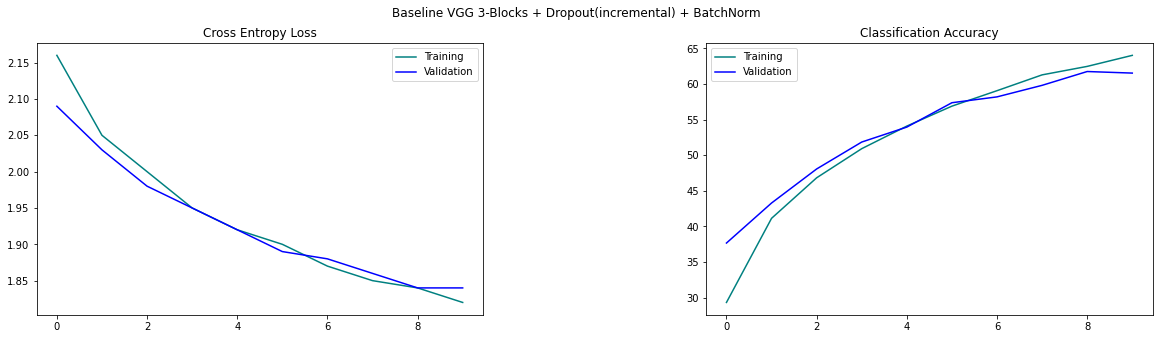

In [40]:
evaluate(cnn_load)